In [1]:
from pyomo.environ import *
from matplotlib import pyplot as plt
import numpy as np


from utils.model import init_model, getM1_rule
from utils.data import load_data, slope_bounds, intercept_bounds

In [2]:
data = load_data('Data/Medication.txt')

CL, CU = slope_bounds(data)
DL, DU = intercept_bounds(data)

C:\Users\padidar\Desktop\CO-Project-Pyomo\utils\data.py:17: RuntimeWarning: invalid value encountered in divide
  slope_min = np.nanmin((y[:, None] - y[None, :]) / (x[:, None] - x[None, :]))
C:\Users\padidar\Desktop\CO-Project-Pyomo\utils\data.py:18: RuntimeWarning: invalid value encountered in divide
  slope_max = np.nanmax((y[:, None] - y[None, :]) / (x[:, None] - x[None, :]))


In [3]:
b = 3
model = init_model(data)
model.b = Param(initialize=b)
model.B = RangeSet(1, b)
model.M = Param(model.I, initialize=getM1_rule(data))

model.c = Var(model.B, within=Reals, bounds=(CL, CU))
model.d = Var(model.B, within=Reals, bounds=(DL, DU))

model.e = Var(within=NonNegativeReals)
model.x = Var(model.I, model.B, within=Binary)

In [4]:
@model.Constraint(model.I, model.B)
def error_constraint_leq(model, i, b):
    return model.Y[i] - model.c[b] * model.X[i] - model.d[b] <= model.e + model.M[i] * (1 - model.x[i, b])


@model.Constraint(model.I, model.B)
def error_constraint_geq(model, i, b):
    return model.Y[i] - model.c[b] * model.X[i] - model.d[b] >= -model.e - model.M[i] * (1 - model.x[i, b])


@model.Constraint(model.I)
def assignment_constraint(model, i):
    return sum(model.x[i, b] for b in model.B) == 1

model.obj = Objective(expr=model.e, sense=minimize)

In [5]:
result = SolverFactory('gurobi', tee=True, keepfiles=False).solve(model)

if result.solver.termination_condition != TerminationCondition.optimal:
    raise Exception('Solver did not find an optimal solution')

print(f'Objective: {model.obj():.2f}')

Objective: 0.41


In [6]:
data_clusters = np.array([sum(model.x[i, b].value * (b - 1) for b in model.B) for i in model.I])

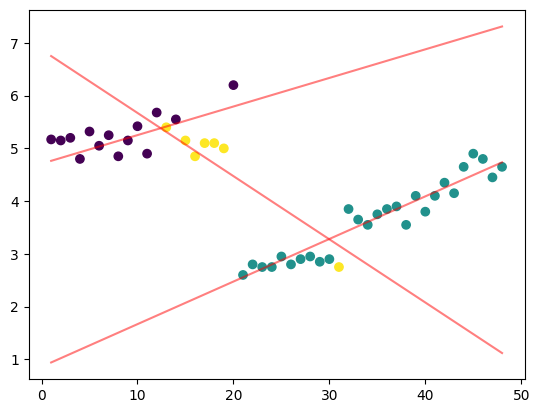

In [7]:
plt.scatter(data[:, 0], data[:, 1], c=data_clusters)
for b in model.B:
    plt.plot(data[:, 0], model.c[b].value * data[:, 0] + model.d[b].value, c='red', alpha=0.5)
plt.show()